In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import Modules and Data

In [ ]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import *
import tensorflow as tf
import os
import random

import warnings
warnings.filterwarnings("ignore")

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [ ]:
# Load train set
df_train = pd.read_csv('/content/drive/My Drive/MSDS 422/Assignment 9/train.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Load test set
df_test = pd.read_csv('/content/drive/My Drive/MSDS 422/Assignment 9/test.csv')
df_test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print("Train data dimensions: ", df_train.shape)
print("Test data dimensions: ", df_test.shape)

Train data dimensions:  (60000, 785)
Test data dimensions:  (5000, 785)


# Explore and Prepare Data

In [ ]:
# Store target variable of training data in a safe place
label_train = df_train.label

# Concatenate training and test sets
data = pd.concat([df_train.drop(['label'], axis=1), df_test])

In [ ]:
data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,id
count,65000.0,65000.0,65000.0,65000.0,65000.0,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,...,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.0,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.000000,65000.0,65000.000000,65000.0,5000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.008138,0.027200,0.034862,0.073769,0.113446,0.195092,0.290677,0.276785,0.227554,0.137169,0.058677,0.024231,0.009615,0.004969,0.002200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004800,0.049738,0.154123,0.324785,0.798246,1.778662,2.931000,...,0.586738,0.509154,0.615185,0.435492,0.274046,0.110400,0.022446,0.006385,0.005062,0.003923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011769,0.071462,0.171431,0.258738,0.410323,0.459292,0.482692,0.475938,0.418708,0.296708,0.128954,0.070477,0.029123,0.023846,0.020831,0.026585,0.011277,0.001277,0.006554,0.0,0.002508,0.0,2499.500000
std,0.0,0.0,0.0,0.0,0.0,1.416435,2.594558,2.619430,3.949229,4.782459,6.203428,7.597353,7.307729,6.567234,5.186040,3.159226,2.219757,1.085557,0.901692,0.560892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.013976,3.364899,5.943111,8.297879,12.873214,19.092555,24.579321,...,10.474498,9.493496,11.385891,9.687298,7.797523,5.122547,2.258588,1.180767,0.943840,1.000192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.732357,4.169100,6.177646,7.341857,9.398769,9.930078,10.229071,10.094445,9.455375,7.793661,4.902623,3.487649,2.183458,2.314896,1.847182,2.273050,1.663053,0.325553,1.184052,0.0,0.639339,0.0,1443.520003
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1249.750000
50%,0.0,0.0,0.0,0.0,0.0,0.00

In [ ]:
# Concise summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65000 entries, 0 to 4999
Columns: 785 entries, pixel0 to id
dtypes: float64(1), int64(784)
memory usage: 389.8 MB


In [ ]:
# Return the number of missing values in each column

def missing_zero_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(data)

Your selected dataframe has 785 columns and 65000 Rows.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,Data Type
id,60000,92.3,float64


In [ ]:
# Save test id
test_id = df_test['id']
data = data.drop('id',axis=1)

# Normalize data
data = data / 255.0

In [ ]:
# Split data back into test and train datasets
data_train = data.iloc[:60000]
data_test = data.iloc[60000:]

In [ ]:
# Split the data into train and validations sets by using train_test_split
from sklearn.model_selection import train_test_split

X = data_train
y = label_train
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

[Text(0.5, 1.0, 'Distribution of Train Label')]

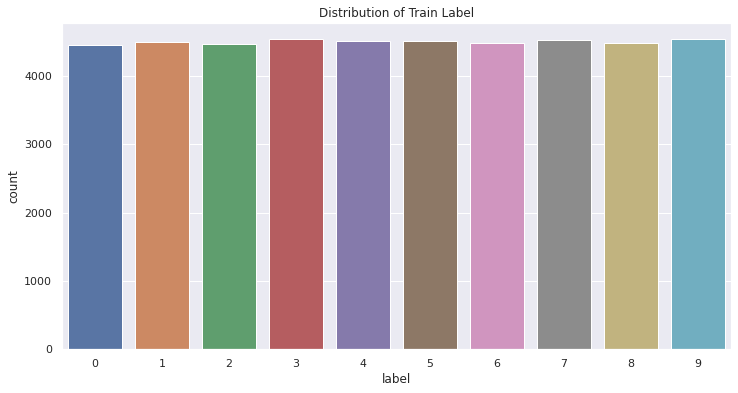

In [ ]:
# Distribution of Train Label
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y_train).set(title="Distribution of Train Label")

[Text(0.5, 1.0, 'Distribution of Validation Label')]

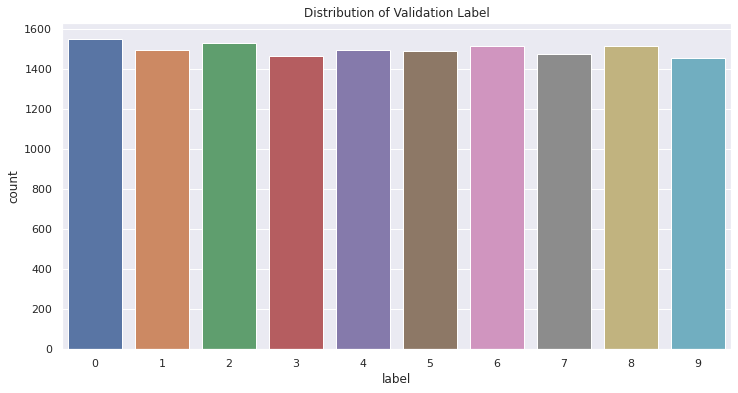

In [ ]:
# Distribution of Validation Label
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(y_valid).set(title="Distribution of Validation Label")

In [ ]:
# Input dimensions
input_dim = np.prod(X_train.shape[1:])

# Reshape image
X_train = X_train.values.reshape((X_train.shape[0], input_dim))
X_valid = X_valid.values.reshape((X_valid.shape[0], input_dim))
data_test = data_test.values.reshape((data_test.shape[0], input_dim))

In [ ]:
# Label encoding
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes = 10)
y_valid = to_categorical(y_valid, num_classes = 10)

# Build Models

## Parameters

In [ ]:
# The dimensionality of the encoded representation.
encoded_dim = 32
num_classes = 10
classifier_units = 100

# Sizes and number of hidden layers.
hidden_layer_weights = [128,64]
hidden_layers = len(hidden_layer_weights)

## Encoding and Decoding Layers

In [ ]:
from keras import regularizers

# Create encoding layers.
def get_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i], activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim, activation='relu')(x)

# Create decoding layers.
def get_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i], activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim, activation='sigmoid', activity_regularizer=regularizers.l1(10e-5))(x)

# Create classifier layers.
def get_classifier(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i], activation='relu')(input if x is None else x)
    return keras.layers.Dense(num_classes, activation='softmax')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack

In [ ]:
import keras

# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))

# Create encoder
encoded_layer = get_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)

# Create decoder
decoded_layer = get_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Create classifier
classifier_layer = get_classifier(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
full_model = keras.models.Model(input, decoded_layer)

# Assemble full classifier model.
classifier_model = keras.models.Model(input, classifier_layer)

# Assemble encoder model.
encoder = keras.models.Model(input, encoded_layer)

# Assemble decoder model (with new input!).
decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, full_model.layers[-(hidden_layers + 1):]))

## Train Autoencoder

In [ ]:
# Compile model
full_model.compile(optimizer=keras.optimizers.Adam()
                   , loss=keras.losses.binary_crossentropy
                   , metrics=keras.metrics.binary_crossentropy)

full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136

In [ ]:
# Use early stopping to stop the training when loss does not decrease anymore.
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]

# Fit model
history = full_model.fit(X_train
               , X_train
               , batch_size=256
               , epochs=200
               , shuffle=True
               , validation_split=.1
               , callbacks=callbacks)

Epoch 1/200
159/159 [==============================] - 15s 11ms/step - loss: 0.3728 - binary_crossentropy: 0.3571 - val_loss: 0.1862 - val_binary_crossentropy: 0.1798
Epoch 2/200
159/159 [==============================] - 1s 8ms/step - loss: 0.1765 - binary_crossentropy: 0.1701 - val_loss: 0.1569 - val_binary_crossentropy: 0.1509
Epoch 3/200
159/159 [==============================] - 1s 8ms/step - loss: 0.1526 - binary_crossentropy: 0.1463 - val_loss: 0.1434 - val_binary_crossentropy: 0.1372
Epoch 4/200
159/159 [==============================] - 1s 8ms/step - loss: 0.1410 - binary_crossentropy: 0.1347 - val_loss: 0.1354 - val_binary_crossentropy: 0.1294
Epoch 5/200
159/159 [==============================] - 1s 8ms/step - loss: 0.1334 - binary_crossentropy: 0.1272 - val_loss: 0.1299 - val_binary_crossentropy: 0.1236
Epoch 6/200
159/159 [==============================] - 1s 8ms/step - loss: 0.1281 - binary_crossentropy: 0.1219 - val_loss: 0.1262 - val_binary_crossentropy: 0.1203
Epoch 7/

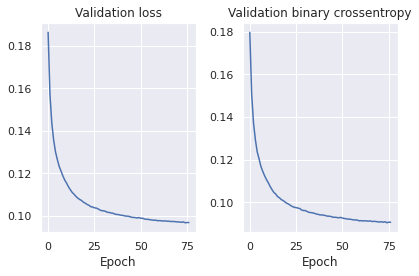

In [ ]:
fig, axes = plt.subplots(1, 2)

val_loss_ax = axes[0]
val_loss_ax.plot(history.history['val_loss'])
val_loss_ax.title.set_text('Validation loss')
val_loss_ax.set_xlabel('Epoch')

val_bincross_ax = axes[1]
val_bincross_ax.plot(history.history['val_binary_crossentropy'])
val_bincross_ax.title.set_text('Validation binary crossentropy')
val_bincross_ax.set_xlabel('Epoch')

plt.tight_layout()
plt.show()

## Visualize Encodings

### Validation Set

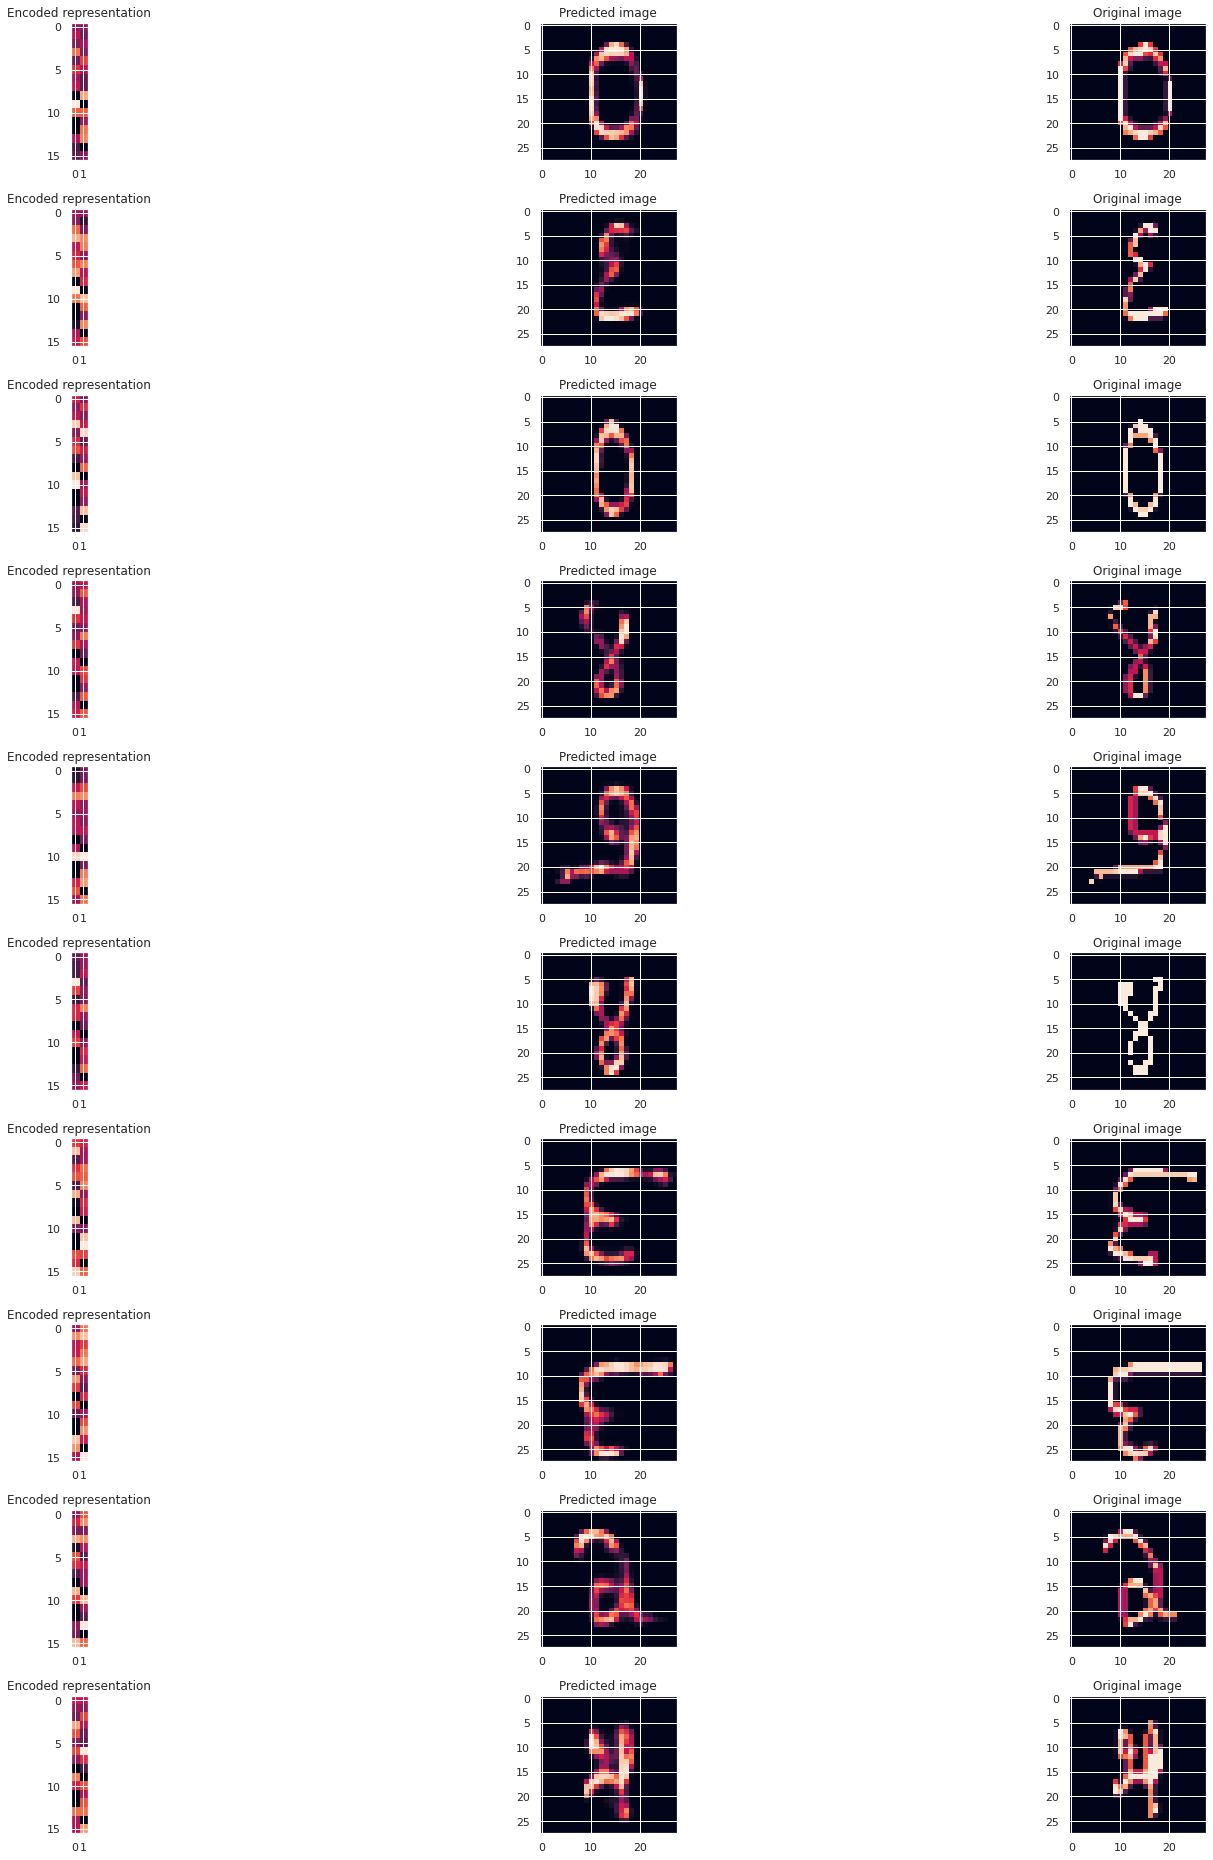

In [ ]:
# Visualize X examples.
num_visualizations = 10
visualization_start_index = np.random.randint(0, len(X_valid))

# Shuffle test images.
np.random.shuffle(X_valid)

fig, axes = plt.subplots(1 * num_visualizations, 3)

for i in range(num_visualizations):
    val_index = visualization_start_index + i
    x_encoded = encoder.predict(X_valid[val_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    
    encoded_columns = 2
    
    # Plot the encoded representation.
    ax_encoded = axes[i][0]
    ax_encoded.imshow(x_encoded.reshape((encoded_dim // encoded_columns, encoded_columns)))
    ax_encoded.title.set_text('Encoded representation')

    # Plot the predicted digit.
    ax_predicted = axes[i][1]
    ax_predicted.imshow(x_predicted.reshape((28, 28)))
    ax_predicted.title.set_text('Predicted image')
    
    # Plot the actual image.
    ax_original = axes[i][2]
    ax_original.imshow(X_valid[val_index].reshape((28, 28)))
    ax_original.title.set_text('Original image')

fig.set_size_inches(26, 26)
plt.tight_layout()
plt.show()

### Test Set

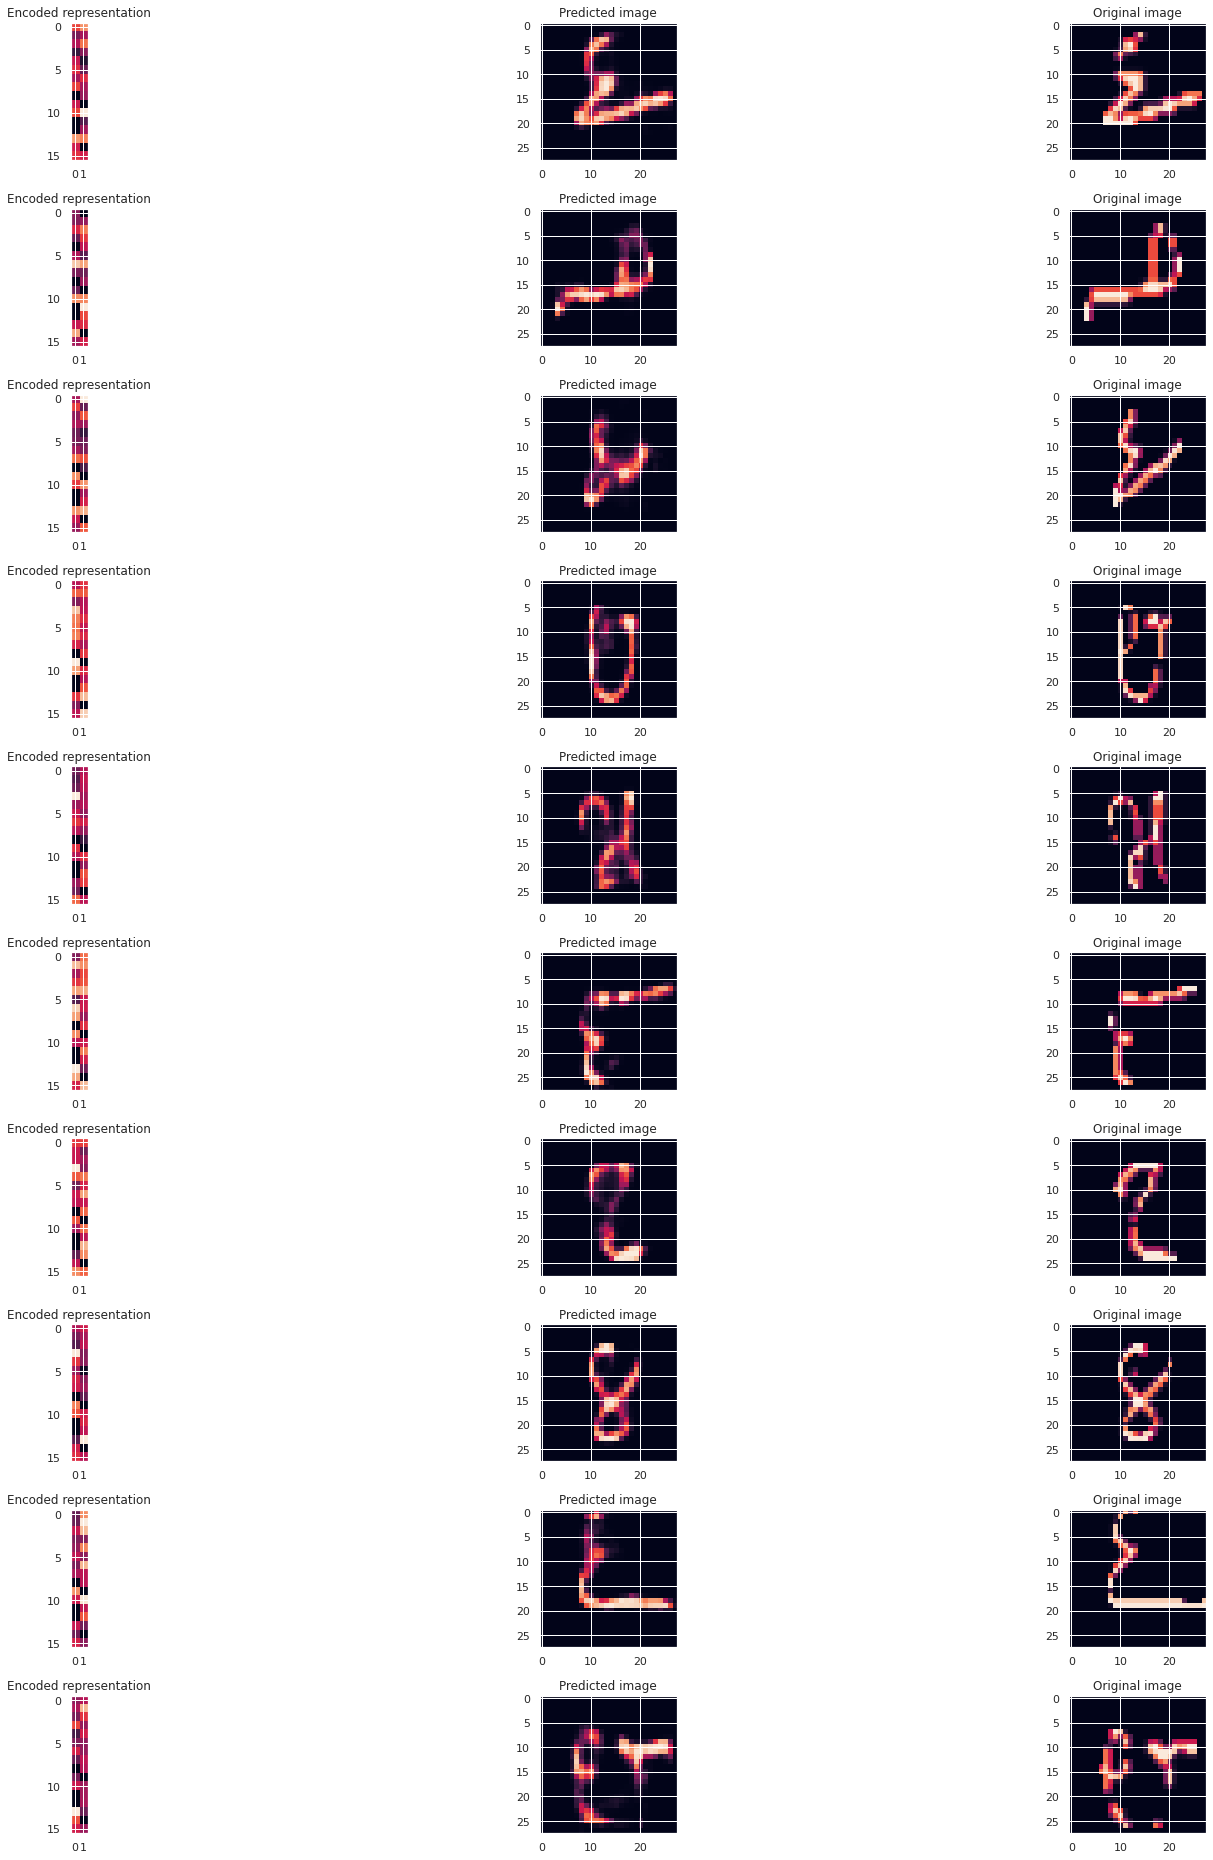

In [ ]:
# Visualize X examples.
num_visualizations = 10
visualization_start_index = np.random.randint(0, len(data_test))

# Shuffle test images.
np.random.shuffle(X_valid)

fig, axes = plt.subplots(1 * num_visualizations, 3)

for i in range(num_visualizations):
    test_index = visualization_start_index + i
    x_encoded = encoder.predict(data_test[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    
    encoded_columns = 2
    
    # Plot the encoded representation.
    ax_encoded = axes[i][0]
    ax_encoded.imshow(x_encoded.reshape((encoded_dim // encoded_columns, encoded_columns)))
    ax_encoded.title.set_text('Encoded representation')

    # Plot the predicted digit.
    ax_predicted = axes[i][1]
    ax_predicted.imshow(x_predicted.reshape((28, 28)))
    ax_predicted.title.set_text('Predicted image')
    
    # Plot the actual image.
    ax_original = axes[i][2]
    ax_original.imshow(data_test[test_index].reshape((28, 28)))
    ax_original.title.set_text('Original image')

fig.set_size_inches(26, 26)
plt.tight_layout()
plt.show()

# Fit Classifier Model

In [ ]:
classifier_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

classifier_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290

In [ ]:
# Use early stopping to stop the training when loss does not decrease anymore.
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

# Fit model
classifier_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(X_valid, y_valid),
    verbose=1,
    callbacks = callbacks
)

Epoch 1/100
176/176 [==============================] - 2s 7ms/step - loss: 0.4753 - binary_accuracy: 0.9194 - val_loss: 1.1876 - val_binary_accuracy: 0.8215
Epoch 2/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0276 - binary_accuracy: 0.9922 - val_loss: 1.4344 - val_binary_accuracy: 0.8212
Epoch 3/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0168 - binary_accuracy: 0.9953 - val_loss: 1.5961 - val_binary_accuracy: 0.8211
Epoch 4/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0129 - binary_accuracy: 0.9962 - val_loss: 1.7726 - val_binary_accuracy: 0.8210
Epoch 5/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0094 - binary_accuracy: 0.9973 - val_loss: 1.8644 - val_binary_accuracy: 0.8210
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 0.0074 - binary_accuracy: 0.9980 - val_loss: 2.0023 - val_binary_accuracy: 0.8209


# Test Data

In [ ]:
'''predict results'''
results = classifier_model.predict(data_test)

'''select the indix with the maximum probability'''
results = np.argmax(results, axis = 1)

submission = pd.DataFrame(test_id)
submission['label'] = results
submission.to_csv('submission.csv',index=False)

from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Kaggle Results

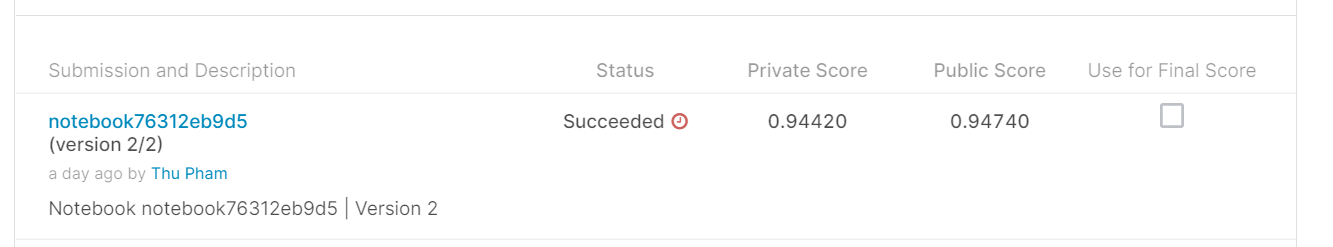

In [ ]:
from PIL import Image

# Kaggle Score - Model 1 & 2
path = "/content/drive/My Drive/MSDS 422/Assignment 9/Results.PNG"
img  = Image.open(path) 
img

# Exposition

The purpose of this project is to correctly identify digits from a dataset of more than sixty thousands of handwritten images. It utilizes autoencoder, which is a neural network model that seeks to learn a compressed representation of an input. There are 2 parts.

In the 1st part, I built and trained an autoencoder model with 2 hidden encoder layers, 1 latent layer, and 2 hidden decoder layers. The validation loss is 0.0967 and the validation binary crossentropy is 0.0905.

In the 2nd part, I built and trained a classifier model with encoder layers similar to the 1st part, but instead of decoder layers I added the classifier ones. The validation binary accuracy is 0.8209 and the Kaggle test accuracy is 0.9474.